In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
df = pd.read_csv('crime_data_2024_to_present.csv')

In [3]:
df[0:2]

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,241110315,2024-08-29,2024-08-28,1500,11,Northeast,1123,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),...,IC,Invest Cont,420.0,NaN,NaN,NaN,3600 BRUNSWICK AV,NaN,34.1187,-118.2604
1,241010884,2024-09-06,2024-09-05,1800,10,West Valley,1027,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,NaN,NaN,NaN,6800 LOUISE AV,NaN,34.1939,-118.5098


In [4]:
df.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62105 entries, 0 to 62104
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DR_NO           62105 non-null  int64  
 1   Date Rptd       62105 non-null  object 
 2   DATE OCC        62105 non-null  object 
 3   TIME OCC        62105 non-null  int64  
 4   AREA            62105 non-null  int64  
 5   AREA NAME       62105 non-null  object 
 6   Rpt Dist No     62105 non-null  int64  
 7   Part 1-2        62105 non-null  int64  
 8   Crm Cd          62105 non-null  int64  
 9   Crm Cd Desc     62105 non-null  object 
 10  Mocodes         43000 non-null  object 
 11  Vict Age        62105 non-null  int64  
 12  Vict Sex        43389 non-null  object 
 13  Vict Descent    43387 non-null  object 
 14  Premis Cd       62099 non-null  float64
 15  Premis Desc     62083 non-null  object 
 16  Weapon Used Cd  3641 non-null   float64
 17  Weapon Desc     3641 non-null  

In [6]:
cols_to_convert = ['DATE OCC', 'Date Rptd']
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_datetime)

In [7]:
df.shape

(62105, 28)

In [8]:
print(f"Date Range: {df['DATE OCC'].min()} to {df['DATE OCC'].max()}")

Date Range: 2024-05-01 00:00:00 to 2025-05-29 00:00:00


In [9]:
df_original = df.copy()

# STEP 2: DATA CLEANING 

In [10]:
invalid_coords = ((df['LAT'] == 0) & (df['LON'] == 0)).sum()
print(f"Found: {invalid_coords:,} records with (0, 0) coordinates")

Found: 0 records with (0, 0) coordinates


In [11]:
zero_age = (df['Vict Age'] == 0).sum()
negative_age = (df['Vict Age'] < 0).sum()
extreme_age = (df['Vict Age'] > 100).sum()


In [12]:
print(zero_age,negative_age,extreme_age)

30096 0 0


In [13]:
df.loc[df['Vict Age'] == 0, 'Vict Age'] = np.nan

In [14]:
initial_count = len(df)
df = df.drop_duplicates(subset=['DR_NO'], keep='first')
removed = initial_count - len(df)
print(removed)

0


In [15]:
df['TIME OCC'] = df['TIME OCC'].astype(str).str.zfill(4)
df['Hour'] = pd.to_numeric(df['TIME OCC'].str[:2], errors='coerce')
df['Minute'] = pd.to_numeric(df['TIME OCC'].str[2:], errors='coerce')
df.loc[df['Hour'] > 23, 'Hour'] = np.nan

df['Day_of_Week'] = df['DATE OCC'].dt.day_name()
df['Month'] = df['DATE OCC'].dt.month
df['Month_Name'] = df['DATE OCC'].dt.month_name()
df['Year'] = df['DATE OCC'].dt.year

df['Time_Period'] = pd.cut(df['Hour'], 
                            bins=[0, 6, 12, 18, 24],
                            labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                            include_lowest=True)

df['Report_Delay_Days'] = (df['Date Rptd'] - df['DATE OCC']).dt.days
df.loc[df['Report_Delay_Days'] < 0, 'Report_Delay_Days'] = 0

In [22]:
df['Vict Sex'].unique()

array([nan, 'M', 'X', 'F', 'H'], dtype=object)

In [23]:
df['Vict Sex'] = df['Vict Sex'].fillna('X')
df['Vict Descent'] = df['Vict Descent'].fillna('X')

In [24]:
df['AREA'].unique()

array([11, 10, 21,  3, 14, 17, 12,  8,  2,  7, 16, 13,  1, 15,  5, 19,  9,
       18,  4, 20,  6])

In [28]:
df['Report_Delay_Days'].describe

<bound method NDFrame.describe of 0        1
1        1
2        2
3        2
4        1
        ..
62100    0
62101    0
62102    1
62103    0
62104    0
Name: Report_Delay_Days, Length: 62105, dtype: int64>

In [16]:
q99 = df['Report_Delay_Days'].quantile(0.99)
df['Report_Delay_Capped'] = df['Report_Delay_Days'].clip(upper=q99)

In [17]:
df['Crm Cd Desc'].unique()

array(['THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
       'BURGLARY FROM VEHICLE', 'TRESPASSING',
       'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
       'VEHICLE - STOLEN', 'THEFT PLAIN - PETTY ($950 & UNDER)',
       'SHOPLIFTING - PETTY THEFT ($950 & UNDER)',
       'THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)',
       'BIKE - STOLEN',
       'VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, BIKES, ETC)',
       'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD',
       'THEFT OF IDENTITY', 'VANDALISM - MISDEAMEANOR ($399 OR UNDER)',
       'PICKPOCKET', 'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
       'ARSON', 'ROBBERY', 'SHOPLIFTING-GRAND THEFT ($950.01 & OVER)',
       'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD',
       'DRIVING WITHOUT OWNER CONSENT (DWOC)', 'BUNCO, PETTY THEFT',
       'BATTERY - SIMPLE ASSAULT', 'BURGLARY', 'VIOLATION OF COURT ORDER',
       'EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)',
       'OTHER MISCELLANEOUS CRIM

In [18]:
violent_keywords = ['ASSAULT', 'ROBBERY', 'RAPE', 'HOMICIDE', 'KIDNAPPING', 
                    'BATTERY', 'WEAPON', 'SHOTS']
df['Is_Violent'] = df['Crm Cd Desc'].str.upper().apply(
    lambda x: any(k in str(x) for k in violent_keywords) if pd.notna(x) else False)

In [20]:
initial = len(df)
df = df[
    df['DATE OCC'].notna() &
    df['Crm Cd'].notna() &
    (df['LAT'].notna() | df['AREA'].notna())
]
removed = initial - len(df)
print(removed)

0


In [21]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

In [22]:
df.columns

Index(['dr_no', 'date_rptd', 'date_occ', 'time_occ', 'area', 'area_name',
       'rpt_dist_no', 'part_1-2', 'crm_cd', 'crm_cd_desc', 'mocodes',
       'vict_age', 'vict_sex', 'vict_descent', 'premis_cd', 'premis_desc',
       'weapon_used_cd', 'weapon_desc', 'status', 'status_desc', 'crm_cd_1',
       'crm_cd_2', 'crm_cd_3', 'crm_cd_4', 'location', 'cross_street', 'lat',
       'lon', 'hour', 'minute', 'day_of_week', 'month', 'month_name', 'year',
       'time_period', 'report_delay_days', 'report_delay_capped',
       'is_violent'],
      dtype='object')

In [23]:
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print("Duplicates removed:", before - after)

Duplicates removed: 0


In [24]:
null_counts = df.isnull().sum().sort_values(ascending=False)
print(null_counts.head(20))


crm_cd_4          62105
crm_cd_3          62079
crm_cd_2          61141
weapon_desc       58464
weapon_used_cd    58464
cross_street      55014
vict_age          30096
mocodes           19105
vict_descent      18718
vict_sex          18716
premis_desc          22
premis_cd             6
status                1
lon                   0
hour                  0
dr_no                 0
minute                0
day_of_week           0
month                 0
month_name            0
dtype: int64


In [25]:
threshold = len(df) * 0.8
df = df.dropna(thresh=threshold, axis=1)
df = df.dropna(subset=['date_occ'])


In [26]:
df['year'] = df['date_occ'].dt.year
df['month'] = df['date_occ'].dt.month
df['day_of_week'] = df['date_occ'].dt.day_name()
df['hour'] = df['date_occ'].dt.hour


In [27]:
numeric_cols = df.select_dtypes(include=np.number).columns

for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    df = df[(df[col] >= lower) & (df[col] <= upper)]


In [28]:
df['crm_cd_desc'].value_counts().head()


crm_cd_desc
VEHICLE - STOLEN                                   12025
BURGLARY FROM VEHICLE                               4550
SHOPLIFTING - PETTY THEFT ($950 & UNDER)            4460
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)     3797
THEFT PLAIN - PETTY ($950 & UNDER)                  3693
Name: count, dtype: int64

In [29]:
df['area_name'].value_counts().head(10)


area_name
Central        3062
Pacific        2871
Southwest      2430
Wilshire       2171
N Hollywood    2090
Hollywood      1882
77th Street    1779
Newton         1779
West LA        1754
Mission        1753
Name: count, dtype: int64

In [30]:
df['year'] = df['date_occ'].dt.year
df['month'] = df['date_occ'].dt.month
df['day_of_week'] = df['date_occ'].dt.day_name()


In [31]:
print(df['day_of_week'].isnull().sum())
print(df['day_of_week'].value_counts())


0
day_of_week
Saturday     5963
Friday       5819
Thursday     5396
Sunday       5286
Wednesday    5257
Monday       5030
Tuesday      5008
Name: count, dtype: int64


In [32]:
df['date_occ'] = pd.to_datetime(df['date_occ'], errors='coerce')
df['date_rptd'] = pd.to_datetime(df['date_rptd'], errors='coerce')


<Axes: xlabel='hour'>

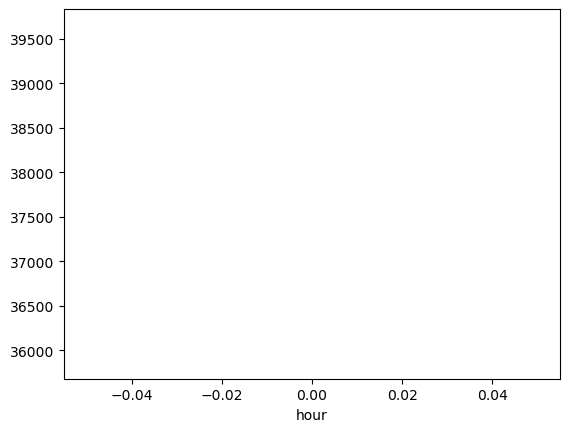

In [33]:
df.groupby('hour').size().plot(kind='line')


<Axes: xlabel='day_of_week'>

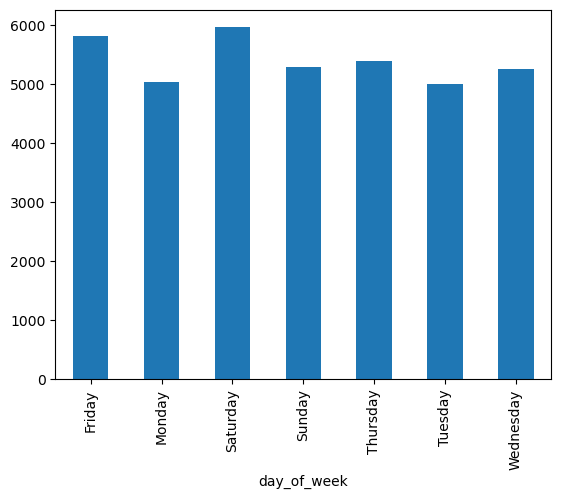

In [34]:
df.groupby('day_of_week').size().plot(kind='bar')


<Axes: xlabel='date_occ'>

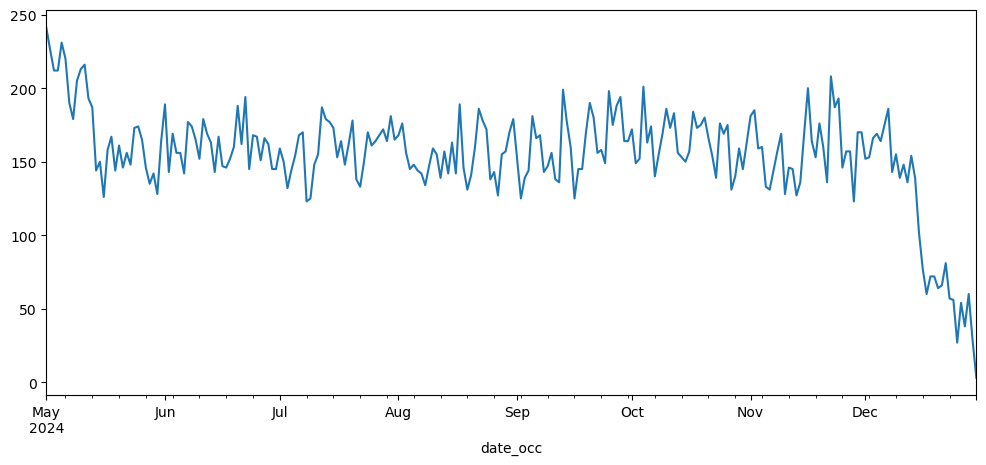

In [35]:
df.groupby('date_occ').size().plot(figsize=(12,5))


In [36]:
df.columns

Index(['dr_no', 'date_rptd', 'date_occ', 'time_occ', 'area', 'area_name',
       'rpt_dist_no', 'part_1-2', 'crm_cd', 'crm_cd_desc', 'premis_cd',
       'premis_desc', 'status', 'status_desc', 'crm_cd_1', 'location', 'lat',
       'lon', 'hour', 'minute', 'day_of_week', 'month', 'month_name', 'year',
       'time_period', 'report_delay_days', 'report_delay_capped',
       'is_violent'],
      dtype='object')